# SQL Stress Testing.
By César Pérez

## Introduction.

In this notebook I'll describe a test to compare the performance of two python SQL libraries, sqlite3 and pyodbc. In particular, I am going to focus on INSERT and SELECT statements. To achieve this, I've created two scripts to increasingly add more rows and columns to an SQLite and MSSQL database and capture the timestamps just before and after the task execution as a way to measure the time taken to complete. Both scripts updates an CSV report containing values such as: operation performed, rows added, existing rows, start / end times and their difference differece. In this notebook, I won't directly describe the scripts that I've used to test the performace, they are available in the links bellow. 

## Hardware / Software Specs.

* **Processor**: Intel(R) Core(TM) i5-10300H CPU \@ 2.50GHz 2.50 GHz

* **RAM**: 16.0 GB (15.8 GB)


* **OS**: Windows 10 Home x64

* **Python Libraries**: sqlite3, pyodbc (4.0.35)

* **Python version**: 3.9.13

## Python 3 Scripts.

* **SQLite**: [testSQLite.py](testSQLite.py)
* **MSSQL**: [testMSSQL.py](testMSSQL.py)

## Limitations.

Even if we want to perform the same operation on both databases, the codes cannot be exacly the same (of course, this is besides elements like connection string of DB file). For the SQLite I've used the method executescript() where the SQL command is build by using string manipulation and then passed as a unique paramenter, when we use this same approach on MSSQL using the execute() method, it will work until around 300 rows, then the results vary from the expected behaviour, for example, writting 320 rows when 500 are expected, to fix this problem, MSSQL script use executemany() that uses a parameter to define parameterized SQL queries and a second one to define the values we want to repeat. This difference is method would impact the validity of the experiment, but will still give us a good insight about the performance we can expect when deciding to use any of these options.

## Performance Analysis.

To analyse the results, I'm going to:
1. Read two CSV files, one having the data from the SQLite database, and the second one from MSSQL.
2. Add an additional column having the source data, this will be just one value per file ('SQLite', 'MSSQL'). 
3. Concatenate both files (for this report I'll exclude a column comming from SQLite, file_size(KB))
4. Create two child tables, one for INSERT statements and the second for SELECT statements. 
5. Create visuals per source and SQL command.

We will keep this report real simple only using two libraries 1. Pandas to manipulate the csv files and 2. Seaborn to create the visuals.

In [2]:
#1. Env prepare
import pandas as pd
import seaborn as sns

In [37]:
# 2. Read and prepare data
SQLite_data = pd.read_csv('report_SQLite.csv')
SQLite_data['source'] = 'SQLite'
SQLite_data.head()

,cols,rows,inserted_rows,start_op,end_op,time_diff,operation,file_size(KB),source
0,1,100,100,2022-07-31 18:03:56.346697,2022-07-31 18:04:00.048014,3.701317,INSERT,160.0,SQLite
1,1,100,100,2022-07-31 18:04:00.063387,2022-07-31 18:04:00.063387,0.000000,SELECT,160.0,SQLite
2,1,300,200,2022-07-31 18:04:00.063387,2022-07-31 18:04:07.452064,7.388677,INSERT,160.0,SQLite
3,1,300,200,2022-07-31 18:04:07.452064,2022-07-31 18:04:07.467377,0.015313,SELECT,160.0,SQLite
4,1,600,300,2022-07-31 18:04:07.467377,2022-07-31 18:04:18.789870,11.322493,INSERT,160.0,SQLite


In [16]:
MSSQL_data = pd.read_csv('report_MSSQL.csv')
MSSQL_data['source'] = 'MSSQL'
MSSQL_data.head()

,cols,rows,inserted_rows,start_op,end_op,time_diff,operation,source
0,1,100,100,2023-02-03 07:42:02.832929,2023-02-03 07:42:02.838674,0.005745,INSERT,MSSQL
1,1,100,100,2023-02-03 07:42:02.853426,2023-02-03 07:42:02.853426,0.000000,SELECT,MSSQL
2,1,300,200,2023-02-03 07:42:02.855421,2023-02-03 07:42:02.865166,0.009745,INSERT,MSSQL
3,1,300,200,2023-02-03 07:42:02.866132,2023-02-03 07:42:02.867129,0.000997,SELECT,MSSQL
4,1,600,300,2023-02-03 07:42:02.868158,2023-02-03 07:42:02.883086,0.014928,INSERT,MSSQL


In [41]:
merged_df = pd.concat([SQLite_data.loc[:, ~SQLite_data.columns.isin(['file_size(KB)'])], MSSQL_data])
merged_df = merged_df.loc[merged_df['time_diff'] < 300] #this step is needed to remove outliers
merged_df_INSERT = merged_df.loc[merged_df['operation'] == 'INSERT']
merged_df_SELECT = merged_df.loc[merged_df['operation'] == 'SELECT']

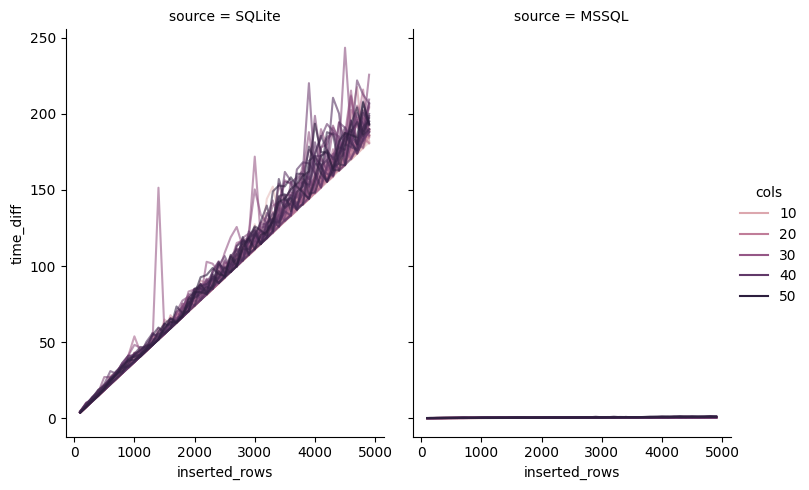

In [48]:
# 3. Results
# Plot the lines on two facets, source https://seaborn.pydata.org/examples/faceted_lineplot.html 
sns.relplot(
    data=merged_df_INSERT,
    x="inserted_rows", 
    y="time_diff", 
    col="source",
    kind="line", 
    hue="cols",
    height=5,
    aspect=.75, 
    facet_kws=dict(sharex=False), 
    alpha = 0.6
)

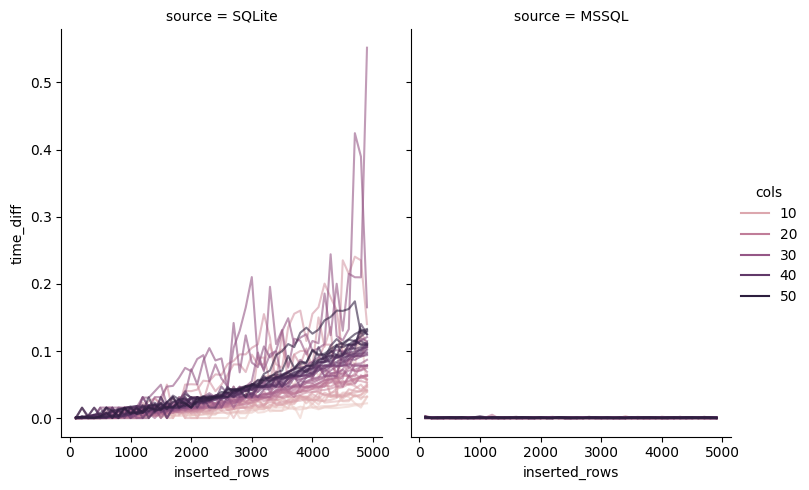

In [47]:
sns.relplot(
    data=merged_df_SELECT,
    x="inserted_rows", 
    y="time_diff", 
    col="source",
    kind="line", 
    hue="cols",
    height=5, 
    aspect=.75, 
    facet_kws=dict(sharex=False), 
    alpha = 0.6
)

## Conclusions

The results indicates that the MSSQL script has a much better performance than the SQLite script. It seems that using SQLite in our scripts will provide portability at the expense of performance. 

## References

**Panda**. McKinney, W., & others. (2010). Data structures for statistical computing in python. In Proceedings of the 9th Python in Science Conference (Vol. 445, pp. 51–56). 

**Seaborn**. Waskom, M., Botvinnik, Olga. Kane, Drew, Hobson, Paul, Lukauskas, Saulius, Gemperline, David C, … Qalieh, Adel. (2017). mwaskom/seaborn: v0.8.1 (September 2017). Zenodo. https://doi.org/10.5281/zenodo.883859